#### Importation des modules

In [1]:
import sys
sys.path.append("/Users/nathan/Python/Data")
from default import *
from functions import *
import pathlib

In [2]:
import re, gc, time, shap, joblib, random
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Unification et exploration

In [3]:
data_path = pathlib.Path('input/')
df_dict = dict()
for file in data_path.glob('*'):
    df_name = file.name.replace('.csv','')
    print(df_name)
    globals()[df_name] = pd.read_csv(file, encoding='Windows-1252')
    globals()[df_name].name = df_name
    df_dict[df_name] = globals()[df_name]

application_test
HomeCredit_columns_description
POS_CASH_balance
credit_card_balance
installments_payments
application_train
bureau
previous_application
bureau_balance
sample_submission


In [4]:
for file in df_dict.keys():
    print(f'Shape of {file} : {df_dict[file].shape}')

Shape of application_test : (48744, 121)
Shape of HomeCredit_columns_description : (219, 5)
Shape of POS_CASH_balance : (10001358, 8)
Shape of credit_card_balance : (3840312, 23)
Shape of installments_payments : (13605401, 8)
Shape of application_train : (307511, 122)
Shape of bureau : (1716428, 17)
Shape of previous_application : (1670214, 37)
Shape of bureau_balance : (27299925, 3)
Shape of sample_submission : (48744, 2)


#### Fonctions de traitement des fichiers du dataset

In [5]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding des variables catégorielles
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Traitement des fichiers application_train.csv et application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    df = pd.read_csv('input/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('input/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Numérisation des variables binaires (0 ou 1)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Traitement des variables catégorielles
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # Traitement des valeurs anomaliques
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Création de variables
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Traitement des fichiers bureau.csv et bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('input/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('input/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Aggregation et unification
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Création de variables
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Traitement des variables catégorielles
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()

    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Traitement de previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('input/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Traitement des valeurs anomaliques
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Traitement des variables catégorielles
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Traitement de POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('input/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Variables créées
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Traitement de installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('input/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Ecarts de paiement
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Jours de retard
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Création de variables : aggrégation des variables numériques
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Traitement de credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('input/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)

    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])

    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

#### Unification du dataset

In [7]:
num_rows = None

df = application_train_test(num_rows)

with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("\nBureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
    
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("\nPrevious applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
    
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("\nPos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
    
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("\nInstallments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
    
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("\nCredit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()

Train samples: 307511, test samples: 48744

Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 27s

Previous applications df shape: (338857, 249)
Process previous_applications - done in 40s

Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 20s

Installments payments df shape: (339587, 26)
Process installments payments - done in 38s

Credit card balance df shape: (103558, 141)
Process credit card balance - done in 29s


In [8]:
# Fonction de calcul des valeurs manquantes
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
                '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values, with " +
               str(np.round(mis_val_table_ren_columns['% of Total Values'].mean(), 1)) +
              "% values missing on average.")
        return mis_val_table_ren_columns

In [9]:
mv = missing_values_table(df)
mv

Your selected dataframe has 798 columns.
There are 617 columns that have missing values, with 32.8% values missing on average.


,Missing Values,% of Total Values
REFUSED_RATE_DOWN_PAYMENT_MAX,303648,85.2
REFUSED_RATE_DOWN_PAYMENT_MIN,303648,85.2
REFUSED_RATE_DOWN_PAYMENT_MEAN,303648,85.2
REFUSED_AMT_DOWN_PAYMENT_MIN,303648,85.2
REFUSED_AMT_DOWN_PAYMENT_MAX,303648,85.2
...,...,...
PAYMENT_RATE,36,0.0
AMT_ANNUITY,36,0.0
INCOME_PER_PERSON,2,0.0
CNT_FAM_MEMBERS,2,0.0


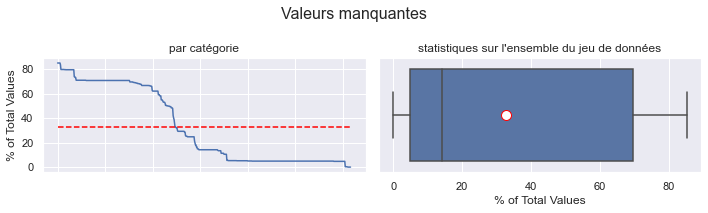

In [68]:
mvm = mv['% of Total Values'].mean()

fig, ax = plt.subplots(1, 2, figsize=(10,3))

mv['% of Total Values'].plot(use_index=False, ax=ax[0])
ax[0].plot([0, len(mv)], [mvm, mvm], ls='--', c='red')
ax[0].axes.get_xaxis().set_ticklabels([])
ax[0].axes.set_ylabel('% of Total Values')

sns.boxplot(mv['% of Total Values'], ax=ax[1], showmeans=True,
            meanprops={"marker": "o", "markeredgecolor": "red", "markerfacecolor": "white", "markersize": "10"})

fig.suptitle('Valeurs manquantes', fontsize=16)
ax[0].set_title('par catégorie')
ax[1].set_title('statistiques sur l\'ensemble du jeu de données')

fig.tight_layout()
plt.show()

# Modélisation en K-fold

In [69]:
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)).drop('index', axis=1)

In [12]:
df.to_csv('credit.csv', index=False)

In [70]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

In [71]:
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
folds = KFold(n_splits= 3, shuffle=True, random_state=42)

In [72]:
# Fonction F-0.5
def fbeta(y, y_pred):
    prec, rec, thres =  metrics.precision_recall_curve(y, y_pred)
    beta = 0.5
    fb = (1+beta**2) * prec * rec / ((beta**2) * prec + rec + 0.0000001)
    return fb.max()

In [73]:
# Métrique d'évaluation
def fb_score(labels, preds):
    is_higher_better = True
    score = fbeta(labels, preds)
    return "fbeta_score", score, is_higher_better

In [74]:
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        
        # Paramètres LightGBM trouvés par optimisation bayésienne
        clf = LGBMClassifier(
            n_jobs=-1,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            verbose=-1)

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric = fb_score, verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, metrics.roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	training's binary_logloss: 0.233988	training's fbeta_score: 0.37119	valid_1's binary_logloss: 0.24132	valid_1's fbeta_score: 0.325524
[400]	training's binary_logloss: 0.223102	training's fbeta_score: 0.414497	valid_1's binary_logloss: 0.2373	valid_1's fbeta_score: 0.336434
[600]	training's binary_logloss: 0.215918	training's fbeta_score: 0.445706	valid_1's binary_logloss: 0.236154	valid_1's fbeta_score: 0.338491
[800]	training's binary_logloss: 0.209815	training's fbeta_score: 0.477523	valid_1's binary_logloss: 0.235607	valid_1's fbeta_score: 0.341345
[1000]	training's binary_logloss: 0.204481	training's fbeta_score: 0.503206	valid_1's binary_logloss: 0.235292	valid_1's fbeta_score: 0.341664
[1200]	training's binary_logloss: 0.199533	training's fbeta_score: 0.528957	valid_1's binary_logloss: 0.235139	valid_1's fbeta_score: 0.34348
[1400]	training's binary_logloss: 0.194783	training's fbeta_score: 0.554399	valid_1's binary_logloss: 0.235128	valid_1's fbeta_score: 0.343553
Fold  1 

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	training's binary_logloss: 0.232473	training's fbeta_score: 0.378938	valid_1's binary_logloss: 0.244453	valid_1's fbeta_score: 0.314747
[400]	training's binary_logloss: 0.221492	training's fbeta_score: 0.420962	valid_1's binary_logloss: 0.240567	valid_1's fbeta_score: 0.32825
[600]	training's binary_logloss: 0.214321	training's fbeta_score: 0.452827	valid_1's binary_logloss: 0.239412	valid_1's fbeta_score: 0.332556
[800]	training's binary_logloss: 0.208344	training's fbeta_score: 0.482852	valid_1's binary_logloss: 0.238845	valid_1's fbeta_score: 0.334396
[1000]	training's binary_logloss: 0.202844	training's fbeta_score: 0.508942	valid_1's binary_logloss: 0.238546	valid_1's fbeta_score: 0.334569
Fold  2 AUC : 0.785741


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	training's binary_logloss: 0.234046	training's fbeta_score: 0.374872	valid_1's binary_logloss: 0.241519	valid_1's fbeta_score: 0.321826
[400]	training's binary_logloss: 0.223313	training's fbeta_score: 0.41933	valid_1's binary_logloss: 0.237562	valid_1's fbeta_score: 0.33169
[600]	training's binary_logloss: 0.216226	training's fbeta_score: 0.449801	valid_1's binary_logloss: 0.236368	valid_1's fbeta_score: 0.337525
[800]	training's binary_logloss: 0.210231	training's fbeta_score: 0.477709	valid_1's binary_logloss: 0.235986	valid_1's fbeta_score: 0.33879
[1000]	training's binary_logloss: 0.204793	training's fbeta_score: 0.503758	valid_1's binary_logloss: 0.235844	valid_1's fbeta_score: 0.340808
[1200]	training's binary_logloss: 0.199814	training's fbeta_score: 0.528231	valid_1's binary_logloss: 0.235746	valid_1's fbeta_score: 0.340961
Fold  3 AUC : 0.790220


# Analyse et choix des seuils

In [75]:
#Calcul de divers F-scores en fonction du seuil choisi

prec, rec, thres =  metrics.precision_recall_curve(train_df['TARGET'], oof_preds)
thres2 = np.append(thres, 1.)
fvalues = pd.DataFrame()

for beta in [0.005, 0.02, 0.1, 0.5, 1.]:
    beta_row = np.full((len(thres2)), beta)
    fb = (1+beta**2) * prec * rec / ((beta**2) * prec + rec)
    temp_df = pd.DataFrame([beta_row, thres2, fb]).transpose()
    fvalues = fvalues.append(temp_df, ignore_index=True)
    del temp_df
    gc.collect()
fvalues.columns = ['beta_row', 'threshold', 'fb']

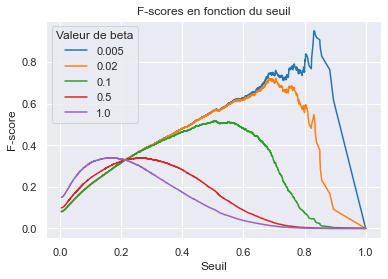

In [78]:
sns.lineplot(data=fvalues, x = 'threshold', y = 'fb', hue = 'beta_row', palette='tab10')
plt.xlabel('Seuil')
plt.ylabel('F-score')
plt.title('F-scores en fonction du seuil')
plt.legend(title='Valeur de beta')
plt.show()

In [79]:
# Tableau des false et true positive rates en foncion du seuil

fpr, tpr, thresholds = metrics.roc_curve(train_df['TARGET'], oof_preds)
rocvalues = pd.DataFrame((fpr, tpr, thresholds)).transpose()
rocvalues.columns = ['fpr', 'tpr', 'threshold']
rocvalues

,fpr,tpr,threshold
0,0.000000,0.000000,1.894759
1,0.000000,0.000040,0.894759
2,0.000000,0.000483,0.830714
3,0.000011,0.000483,0.822091
4,0.000011,0.000765,0.803626
...,...,...,...
40463,0.998217,0.999919,0.004357
40464,0.998217,0.999960,0.004351
40465,0.998833,0.999960,0.004008
40466,0.998833,1.000000,0.004006


In [80]:
# Seuil afin d'optimisier F-0.1
good_idx01 = fvalues[fvalues['beta_row']==0.1]['fb'].idxmax()
good_thr01 = fvalues.loc[good_idx01, 'threshold']
good_thr01

0.5057409470985335

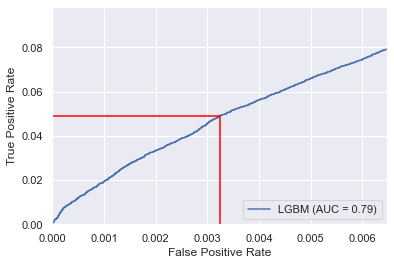

In [81]:
fpr_cut01, tpr_cut01 = rocvalues[rocvalues['threshold'] <= good_thr01][['fpr', 'tpr']].iloc[0]
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=metrics.auc(fpr, tpr), estimator_name='LGBM')
display.plot()
plt.plot([0, fpr_cut01], [tpr_cut01, tpr_cut01], ls='solid', c='red')
plt.plot([fpr_cut01, fpr_cut01], [0, tpr_cut01], ls='solid', c='red')
plt.axis([0, 2*fpr_cut01, 0, 2*tpr_cut01])
plt.show()

In [82]:
# Seuil afin d'optimisier F-0.5
good_idx05 = fvalues[fvalues['beta_row']==0.5]['fb'].idxmax()
good_thr05 = fvalues.loc[good_idx05, 'threshold']
good_thr05

0.2570909768742404

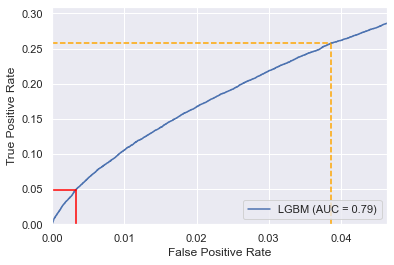

In [83]:
fpr_cut05, tpr_cut05 = rocvalues[rocvalues['threshold'] <= good_thr05][['fpr', 'tpr']].iloc[0]
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=metrics.auc(fpr, tpr), estimator_name='LGBM')
display.plot()
plt.plot([0, fpr_cut01], [tpr_cut01, tpr_cut01], ls='solid', c='red')
plt.plot([fpr_cut01, fpr_cut01], [0, tpr_cut01], ls='solid', c='red')
plt.plot([0, fpr_cut05], [tpr_cut05, tpr_cut05], ls='--', c='orange')
plt.plot([fpr_cut05, fpr_cut05], [0, tpr_cut05], ls='--', c='orange')
plt.axis([0, 1.2*fpr_cut05, 0, 1.2*tpr_cut05])
plt.show()

In [84]:
# Seuil afin d'optimisier F-1
good_idx1 = fvalues[fvalues['beta_row']==1.]['fb'].idxmax()
good_thr1 = fvalues.loc[good_idx1, 'threshold']
good_thr1

0.17309633808609315

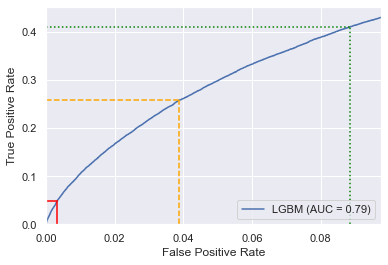

In [85]:
fpr_cut1, tpr_cut1 = rocvalues[rocvalues['threshold'] <= good_thr1][['fpr', 'tpr']].iloc[0]
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=metrics.auc(fpr, tpr), estimator_name='LGBM')
display.plot()
plt.plot([0, fpr_cut01], [tpr_cut01, tpr_cut01], ls='solid', c='red')
plt.plot([fpr_cut01, fpr_cut01], [0, tpr_cut01], ls='solid', c='red')
plt.plot([0, fpr_cut05], [tpr_cut05, tpr_cut05], ls='--', c='orange')
plt.plot([fpr_cut05, fpr_cut05], [0, tpr_cut05], ls='--', c='orange')
plt.plot([0, fpr_cut1], [tpr_cut1, tpr_cut1], ls=':', c='green')
plt.plot([fpr_cut1, fpr_cut1], [0, tpr_cut1], ls=':', c='green')
plt.axis([0, 1.1*fpr_cut1, 0, 1.1*tpr_cut1])
plt.show()

In [86]:
rates_df = pd.DataFrame([[tpr_cut01, tpr_cut05, tpr_cut1],
                         [fpr_cut01, fpr_cut05, fpr_cut1],
                        [good_thr01, good_thr05, good_thr1]]).transpose()
rates_df.columns = ['TPR', 'FPR', 'Threshold']
rates_df['TPR/FPR'] = rates_df['TPR']/rates_df['FPR']
rates_df = rates_df.round(3)
rates_df

,TPR,FPR,Threshold,TPR/FPR
0,0.049,0.003,0.506,15.166
1,0.258,0.039,0.257,6.666
2,0.411,0.089,0.173,4.635


# Fitting de l'intégralité du jeu de données

In [3]:
df = pd.read_csv('credit.csv')

In [4]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

In [89]:
clf = LGBMClassifier(
            n_jobs=-1,
            n_estimators=1400,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            verbose=-1)

clf.fit(train_df[feats], train_df['TARGET'])

LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=1400, num_leaves=34, reg_alpha=0.041545473,
               reg_lambda=0.0735294, subsample=0.8715623, verbose=-1)

In [6]:
joblib.dump(clf, 'clf.pkl')

['clf.pkl']

In [100]:
scores_predicted = clf.predict_proba(train_df[feats])[:, 1]
print('Lorsque l\'on optimise les scores F-0.1, 0.5 et 1, les taux de validation de crédit prédits par rapport au \
nombre réel de remboursements du jeu d\'entrainement sont respectivement de {:.1f}%, {:.1f}% et {:.1f}%.'.format(
((scores_predicted >= good_thr01).sum())*100 / train_df['TARGET'].sum(),
((scores_predicted >= good_thr05).sum())*100 / train_df['TARGET'].sum(),
((scores_predicted >= good_thr1).sum())*100 / train_df['TARGET'].sum()))

Lorsque l'on optimise les scores F-0.1, 0.5 et 1, les taux de validation de crédit prédits par rapport au nombre réel de remboursements du jeu d'entrainement sont respectivement de 11.0%, 73.9% et 145.5%.


# SHAP

In [6]:
X = df[feats]

In [5]:
clf = joblib.load('clf.pkl')

In [139]:
explainer = shap.Explainer(clf, X)

In [47]:
shap_values = explainer(X, check_additivity=False)

100%|===================| 356227/356251 [263:20<00:01]         

In [17]:
# Export des valeurs de SHAP, afin d'être utilisées par l'API
joblib.dump(shap_values, 'shap_values_comp.pkl', compress=True)
joblib.dump(shap_values.values, 'shap_exp_values.pkl', compress=True)
joblib.dump(shap_values.base_values, 'shap_exp_base_values.pkl', compress=True)
joblib.dump(shap_values.data, 'shap_exp_data.pkl', compress=True)
joblib.dump(shap_values.feature_names, 'shap_exp_feat_names.pkl', compress=True)

['shap_exp_values.joblib']

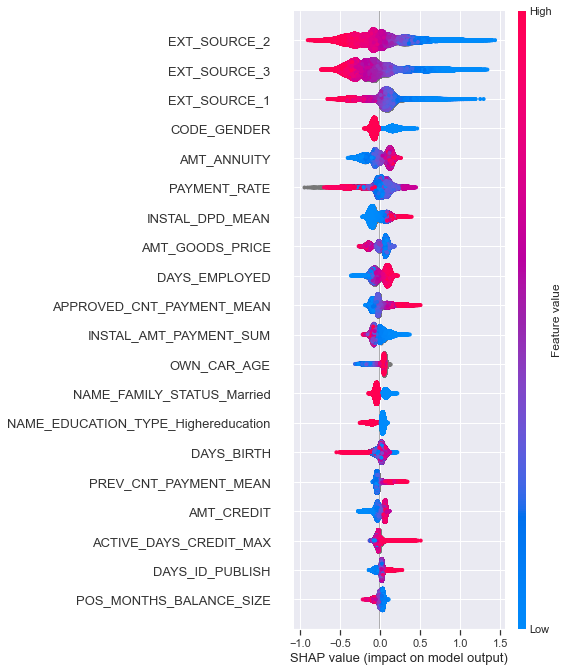

In [54]:
shap.summary_plot(shap_values)

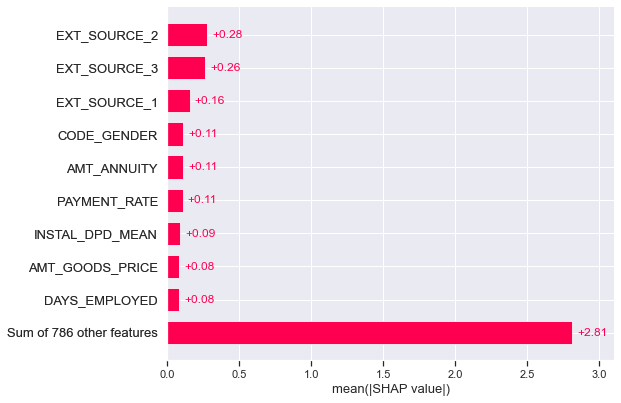

In [108]:
shap.plots.bar(shap_values)

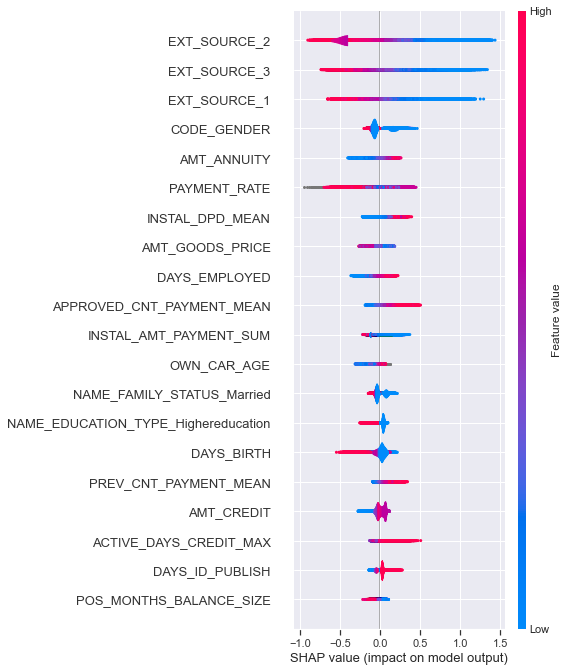

In [56]:
shap.summary_plot(shap_values, plot_type='violin')

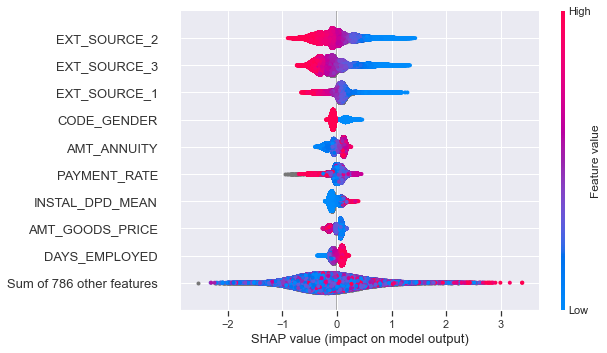

In [124]:
shap.plots.beeswarm(shap_values)

## SHAP light (fitting sur une fraction du jeu de données afin de pouvoir déployer l'application

In [19]:
credit_light_ind = pd.Index(random.sample(set(df.index), k=1000))

In [138]:
pd.Series(credit_light_ind).to_csv('credit_light_ind.csv', index=False)

In [145]:
credit_light = df.loc[credit_light_ind]
credit_light

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,,,,,,,,,,,,,,,,,,,,,
36187,141905,0.0,1,1,1,0,193500.0,755190.0,36459.0,675000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128343,248872,0.0,1,0,1,0,216000.0,1575000.0,43312.5,1575000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0
237101,374627,0.0,1,1,0,0,51750.0,1040985.0,30564.0,909000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.0
34539,140023,0.0,1,0,1,0,135000.0,792162.0,40576.5,630000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135621,257301,0.0,1,0,0,0,76500.0,549882.0,16209.0,459000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205931,338697,0.0,1,0,0,1,180000.0,685386.0,43803.0,585000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263388,404958,0.0,0,1,0,0,270000.0,640080.0,31261.5,450000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0
246577,385370,0.0,1,1,0,0,76500.0,225000.0,22383.0,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [196]:
credit_light.to_csv('credit_light.csv', index = False)
credit_light['SK_ID_CURR'].to_csv('credit_light_sk_id.csv', index = False)

In [147]:
X = credit_light[feats]

In [148]:
explainer = shap.Explainer(clf, X)

In [149]:
shap_values = explainer(X, check_additivity=False)

 99%|===================| 993/1000 [00:59<00:00]        

In [27]:
joblib.dump(shap_values.values, 'shap_light_values.pkl', compress=True)
joblib.dump(shap_values.base_values, 'shap_light_base_values.pkl', compress=True)
joblib.dump(shap_values.feature_names, 'shap_light_feat_names.pkl', compress=True)

['shap_light_values.pkl']

In [153]:
shap.initjs()
shap.force_plot(shap_values[:10])

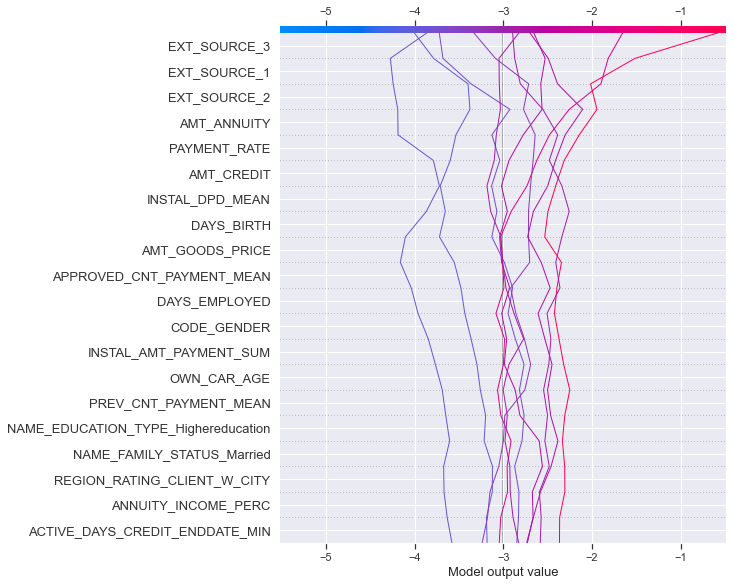

In [180]:
shap.decision_plot(shap_values[0].base_values, shap_values[:10].values, shap_values.feature_names)